# Import relevant toolboxes

In [1]:
%matplotlib widget                                           
import matplotlib.pyplot as plt                       # for plotting
import os                                             # for navigating folders
import pandas as pd                                   # for displaying final data table
from TFM_Image_registration import *                  # for aligning images
from TFM_displacement_tools import TFM_optical_flow   # for calculating substrate displacement
from TFM_tools import *                               # for calculating forces

### If performing image corrections

In [2]:
# read in flat field correction images
green_flatfield =io.imread('test_flatfield_images/488_flatfield.tif')
red_flatfield = io.imread('test_flatfield_images/561short_flatfield.tif')
farred_flatfield = io.imread('test_flatfield_images/640long_flatfield.tif')
darkfield_image = io.imread('test_flatfield_images/Prime_darkfield.tif')

## Run analysis in the correct directory

In [3]:
# switch to the test_cell directory
os.chdir('test_cell/')

# Define experiment parameters


In [4]:
shear_modulus = 16000
um_per_pixel = .1746

# Register images

In [5]:
TFM_Image_registration(flatfield_correct = True, 
                       flatfield_images=[farred_flatfield,green_flatfield,red_flatfield],
                       darkfield_image=darkfield_image,
                       image_list = ['488.tif','561short.tif'])

# Calculate the displacements in the substrate

In [6]:
TFM_optical_flow(pyr_scale = 0.5, levels = 5, winsize = 8, iterations = 3, poly_n = 3, poly_sigma = 0.5)

# Determine the best regularization parameter

There are multiple ways to do this. 
1. If you have scikit-sparse installed you can perform the Bayesian routine developed by Huang et al (https://doi.org/10.1016/j.cpc.2020.107313)
2. You can generate results from a series of different regularization parameters and decide which is the best one

Regardless of the method used, the same regularization parameter should be used across a set of experiments. If you use different regularization parameters you cannot compare results directly between data sets.


In [7]:
# option 1
LL = find_regularization_parameter(shear_modulus = shear_modulus)

print('LL: ', LL)

LL:  4.038560625410912e-09


In [8]:
# option 2
imagestack = io.imread('640long_registered.tif')
reference_image = io.imread('640long_reference.tif')

reg_guess, reg_check_stack = generate_regparam_stack(imagestack, reference_image, plane=0,
                                                     shear_modulus=shear_modulus, um_per_pixel = um_per_pixel,
                                                     N_guesses=30, reg_min=1e-9, reg_max=1e-5,
                                                    save_stack = True)

print(reg_guess)

[1.00000000e-09 1.37382380e-09 1.88739182e-09 2.59294380e-09
 3.56224789e-09 4.89390092e-09 6.72335754e-09 9.23670857e-09
 1.26896100e-08 1.74332882e-08 2.39502662e-08 3.29034456e-08
 4.52035366e-08 6.21016942e-08 8.53167852e-08 1.17210230e-07
 1.61026203e-07 2.21221629e-07 3.03919538e-07 4.17531894e-07
 5.73615251e-07 7.88046282e-07 1.08263673e-06 1.48735211e-06
 2.04335972e-06 2.80721620e-06 3.85662042e-06 5.29831691e-06
 7.27895384e-06 1.00000000e-05]


In [9]:
# if using the value from option 1, we typically find that it overestimates the regularization parameter and that it should be multiplied by a factor of 10-100
# regularization_parameter = LL * 10  

# alternatively you can define it from the list above
regularization_parameter = reg_guess[12]

print('Regularization parameter: ', regularization_parameter)

Regularization parameter:  4.5203536563602405e-08


## Perform FTTC calculation

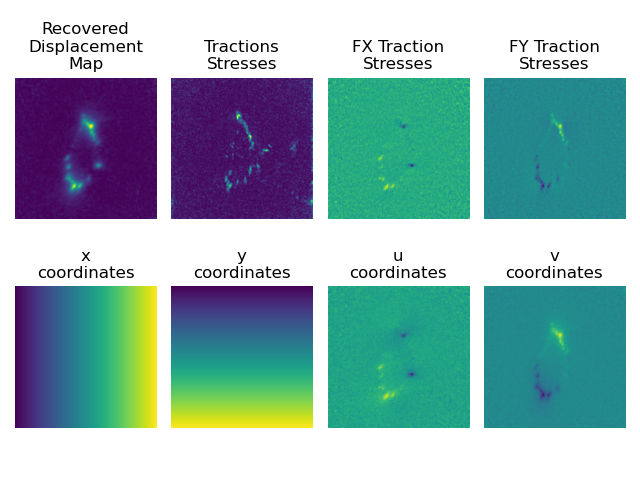

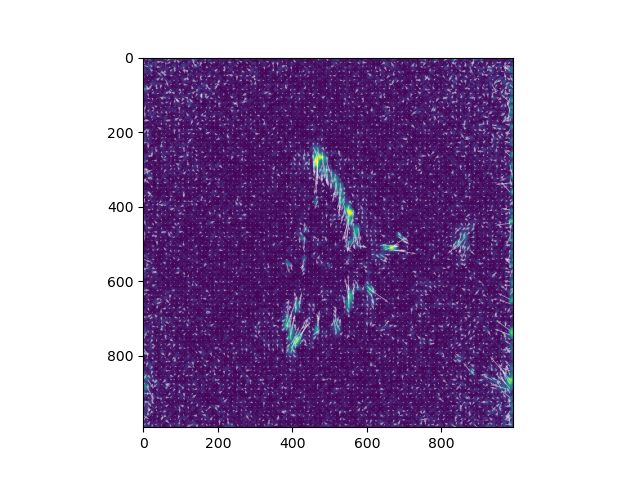

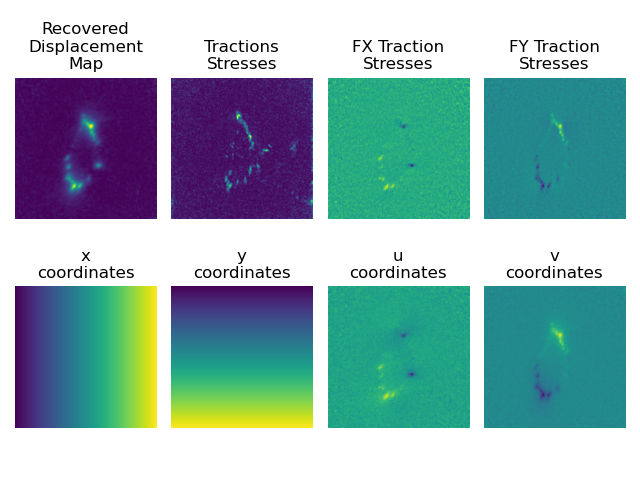

In [10]:
TFM_calculation(shear_modulus=shear_modulus, um_per_pixel=um_per_pixel, 
                regparam = regularization_parameter, 
                downsample = 12, timepoint = 1, check_figure=True)

## Create a mask to analyze forces only around the  cell

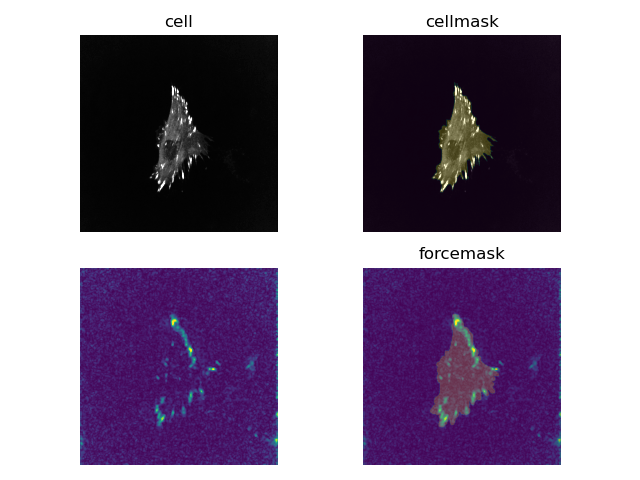

In [11]:
cellmask_stack, forcemask_stack, threshold = cellmask_threshold('561short_registered.tif', 
                                                                small_object_size=50, 
                                                                cell_minimum_area=50000, 
                                                                dilation_size = 10, 
                                                                save_figure=True, 
                                                                plot_figure=True, 
                                                                timepoint = 0)

## Calculate the strain energy and other relevant parameters

In [12]:
TFM_analysis()

## For displaying data

In [13]:
# read in data
data =  pd.read_csv('TFM_analysis.csv', index_col=0)

# display first 5 rows of data
data.head()

,time,cell_area_microns2,force_minimum,force_sum_Pa,displacement_sum,residual,energy_pJ,energy_per_area
0,0,2328.547976,0,73195820.0,98113.080,13.695060,0.332075,0.000143
1,1,2282.820236,0,51177756.0,60714.300,12.462516,0.134261,0.000059
2,2,2229.196840,0,33316234.0,24016.533,5.397630,0.027275,0.000012
3,3,2039.914481,0,29896396.0,21744.088,4.834672,0.021951,0.000011
4,4,1882.854937,0,24002166.0,14852.623,3.341681,0.011675,0.000006


# Display a cropped image with arrows overlaid

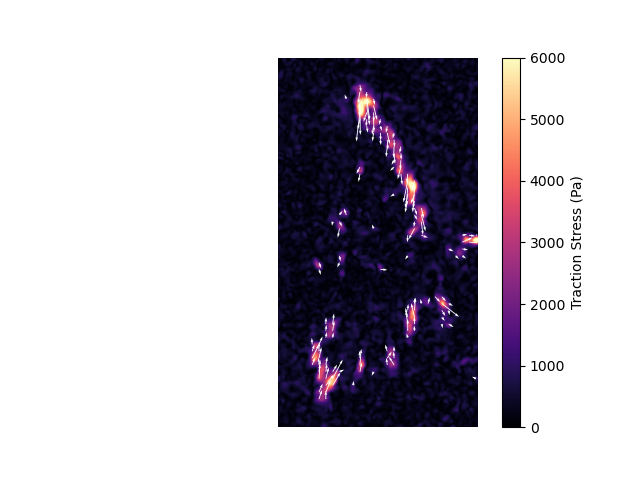

In [14]:
crop_TFM_image(frame = 0, width = 350, height = 650, corner = (190,320), 
               TFM_min = 0, TFM_max = 6000, LUT = 'magma', colorbar = True,
               min_arrow_mag = 1000, arrow_color = 'w', 
               arrow_spacing = 12, arrow_width = 1.5,  arrow_scale = None,
               save_fig = True, file_type = 'PNG', base_folder = '', 
               show_fig = True)